In [ ]:
!pip install kaggle
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 16
    EPOCHS = 15
    TARGET_COLS = [
        "bowel"
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [ ]:
keras.utils.set_random_seed(seed=config.SEED)

In [ ]:
BASE_PATH = "/content/drive/MyDrive/rsna_data"

In [ ]:
# CSV 파일을 읽어와서 데이터프레임 생성
train_df = pd.read_csv(f"{BASE_PATH}/train.csv")
series_meta_df = pd.read_csv(f"{BASE_PATH}/train_series_meta.csv")

# train.csv와 train_series_meta.csv를 patient_id를 기준으로 병합
dataframe = pd.merge(train_df, series_meta_df, on="patient_id")

# 이미지 경로 생성
dataframe["image_path"] = f"/content/drive/MyDrive/png_jjw"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + "img_256x256_d1_original"


In [ ]:
def bowel_assign_value(row):
    if row['bowel_healthy'] == 1:
        return 0
    else:
        return 1

dataframe['bowel'] = dataframe.apply(bowel_assign_value, axis=1)

In [ ]:
dataframe[["patient_id", "bowel", "image_path"]]

,patient_id,bowel,image_path
0,10004,0,/content/drive/MyDrive/png_jjw/10004/21057/img...
1,10004,0,/content/drive/MyDrive/png_jjw/10004/51033/img...
2,10005,0,/content/drive/MyDrive/png_jjw/10005/18667/img...
3,10007,0,/content/drive/MyDrive/png_jjw/10007/47578/img...
4,10026,0,/content/drive/MyDrive/png_jjw/10026/29700/img...
...,...,...,...
4706,9961,0,/content/drive/MyDrive/png_jjw/9961/2003/img_2...
4707,9961,0,/content/drive/MyDrive/png_jjw/9961/63032/img_...
4708,9980,0,/content/drive/MyDrive/png_jjw/9980/40214/img_...
4709,9980,0,/content/drive/MyDrive/png_jjw/9980/40466/img_...


In [ ]:
negative = dataframe[dataframe['bowel'] == 0]
positive = dataframe[dataframe['bowel'] == 1]
num_samples = min(len(negative), len(positive))
negative_samples = negative.sample(n=num_samples, random_state=42)
positive_samples = positive.sample(n=num_samples, random_state=42)
bowel_dataframe = pd.concat([negative_samples, positive_samples], axis=0)

In [ ]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, stratify=group["bowel"], test_size=test_size, random_state=42)

# Initialize the train and validation datasets
bowel_train_data = pd.DataFrame()
bowel_val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in bowel_dataframe.groupby(config.TARGET_COLS):
    bowel_train_group, bowel_val_group = split_group(group)
    bowel_train_data = pd.concat([bowel_train_data, bowel_train_group], ignore_index=True)
    bowel_val_data = pd.concat([bowel_val_data, bowel_val_group], ignore_index=True)


<ipython-input-13-41de00a524fb>:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in bowel_dataframe.groupby(config.TARGET_COLS):


In [ ]:
def decode_image_and_label(image_path, label):
    file_bytes1 = tf.io.read_file(image_path+'/image_001.png')
    image1 = tf.io.decode_png(file_bytes1, channels=1, dtype=tf.uint8)
    file_bytes2 = tf.io.read_file(image_path+'/image_002.png')
    image2 = tf.io.decode_png(file_bytes2, channels=1, dtype=tf.uint8)
    file_bytes3 = tf.io.read_file(image_path+'/image_003.png')
    image3 = tf.io.decode_png(file_bytes3, channels=1, dtype=tf.uint8)
    image = tf.concat([image1, image2, image3], axis=2)

    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)

    return (image, label)

In [ ]:
# 레이어 외부에서 RandomFlip 레이어를 생성
random_flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
random_rotation_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)

class CustomAugmenter(tf.keras.layers.Layer):
    def __init__(self, cutout_params, **kwargs):
        super(CustomAugmenter, self).__init__(**kwargs)
        self.cutout_layer = keras_cv.layers.Augmenter([keras_cv.layers.RandomCutout(**cutout_params)])

    def call(self, inputs, training=None):
        if training:
            inputs = random_flip_layer(inputs)
            inputs = random_rotation_layer(inputs)
            inputs = self.cutout_layer(inputs)
        return inputs

def apply_augmentation(images, labels):
    # 이미지 증강 파이프라인을 정의
    augmenter = CustomAugmenter(cutout_params={"height_factor": 0.2, "width_factor": 0.2})

    # 이미지 증강을 적용
    augmented_images = augmenter(images, training=True)

    return (augmented_images, labels)

In [ ]:
def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)  # 이미지 증강 적용
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [ ]:
paths = bowel_train_data.image_path.tolist()
labels = bowel_train_data[config.TARGET_COLS].values
print(len(paths))
print(labels.shape)

166
(166, 1)


In [ ]:
paths = bowel_train_data.image_path.tolist()
labels = bowel_train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([16, 256, 256, 3]),
 [TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1]),
  TensorShape([1])])

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Custom metric to calculate sensitivity
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 1)), dtype=tf.float32))
    actual_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), dtype=tf.float32))
    return true_positives / (actual_positives + tf.keras.backend.epsilon())

# Custom metric to calculate specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 0)), dtype=tf.float32))
    actual_negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, 0), dtype=tf.float32))
    return true_negatives / (actual_negatives + tf.keras.backend.epsilon())

In [ ]:
def build_binary_classification_model(warmup_steps, decay_steps, head_name):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b3")
    backbone.include_rescaling = False
    x = backbone(inputs)

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for the binary classification head
    x_head = keras.layers.Dense(32, activation='silu')(x)

    # Define binary classification head
    output = keras.layers.Dense(1, name=head_name, activation='sigmoid')(x_head)

    # Create model
    print(f"[INFO] Building the {head_name} model...")
    model = keras.Model(inputs=inputs, outputs=output)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = keras.losses.BinaryCrossentropy()
    metrics = ["accuracy", sensitivity, specificity]

    print(f"[INFO] Compiling the {head_name} model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

def build_tertiary_classification_model(warmup_steps, decay_steps, head_name):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b3")
    backbone.include_rescaling = False
    x = backbone(inputs)

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for the tertiary classification head
    x_head = keras.layers.Dense(32, activation='silu')(x)

    # Define tertiary classification head
    output = keras.layers.Dense(3, name=head_name, activation='softmax')(x_head)

    # Create model
    print(f"[INFO] Building the {head_name} model...")
    model = keras.Model(inputs=inputs, outputs=output)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = keras.losses.CategoricalCrossentropy()
    metrics = ["accuracy"]

    print(f"[INFO] Compiling the {head_name} model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

In [ ]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = bowel_train_data.image_path.values; train_labels = bowel_train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = bowel_val_data.image_path.values; valid_labels = bowel_val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=2640
warmup_steps=264
decay_steps=2376


[INFO] Building the bowel model...
[INFO] Compiling the bowel model...
Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1637s 104s/step - accuracy: 0.3976 - loss: 0.7236 - mean_metric_wrapper: 0.3934 - mean_metric_wrapper_1: 0.3941 - val_accuracy: 0.5000 - val_loss: 0.7236 - val_mean_metric_wrapper: 0.0000e+00 - val_mean_metric_wrapper_1: 1.0000
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 595s 52s/step - accuracy: 0.4703 - loss: 0.7133 - mean_metric_wrapper: 0.5031 - mean_metric_wrapper_1: 0.4883 - val_accuracy: 0.5000 - val_loss: 0.6929 - val_mean_metric_wrapper: 1.0000 - val_mean_metric_wrapper_1: 0.0000e+00
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 580s 53s/step - accuracy: 0.5737 - loss: 0.7045 - mean_metric_wrapper: 0.6725 - mean_metric_wrapper_1: 0.5105 - val_accuracy: 0.5000 - val_loss: 0.6934 - val_mean_metric_wrapper: 0.0000e+00 - val_mean_metric_wrapper_1: 1.0000
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 607s 51s/step - accuracy: 0.5899 - loss: 0.6743 - mean_metric_wrapper: 0.5051 - mean_metric_wrapp

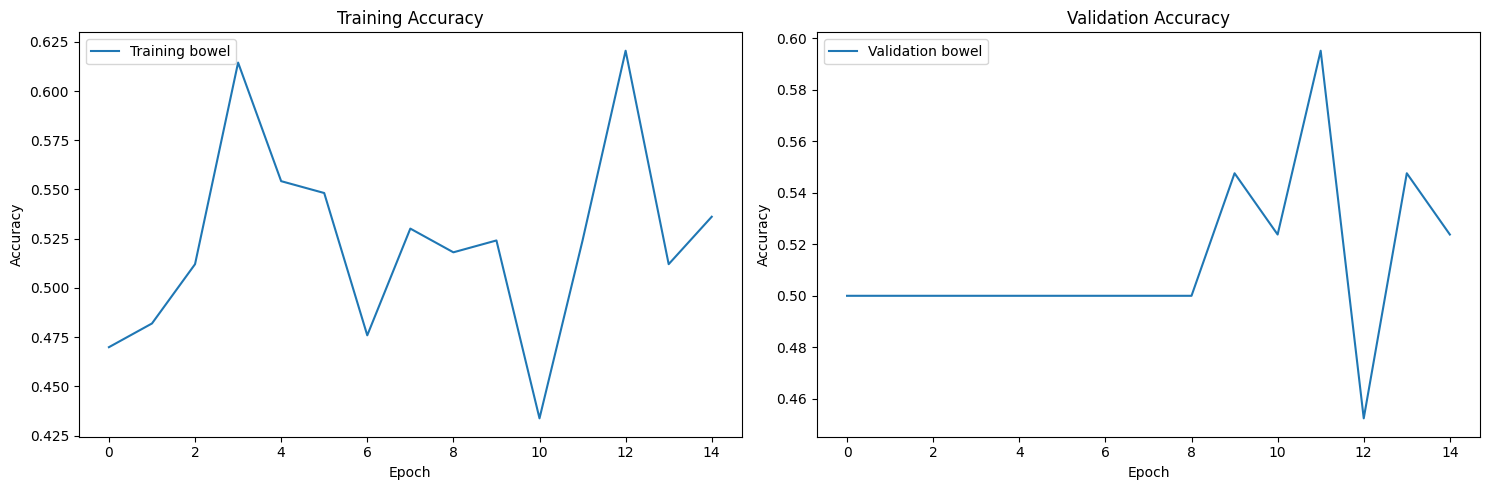

In [ ]:
# Directory where you want to save the models
save_dir = BASE_PATH + "/checkpoint/"

# List of model names
model_names = ["bowel"]

# Create a 1x2 grid for the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Flatten axes to iterate through them
axes = axes.flatten()

for i, name in enumerate(model_names):
    # Build the model
    if name in ["bowel", "extra"]:
        model = build_binary_classification_model(warmup_steps, decay_steps, name)
    else:
        model = build_tertiary_classification_model(warmup_steps, decay_steps, name)

    # Train the model
    history = model.fit(train_ds, epochs=config.EPOCHS, validation_data=val_ds)

    model_filename = f"EfficinetnetB3_{name}.keras"
    model_path = os.path.join(save_dir, model_filename)
    model.save(model_path)

    # Plot training accuracy
    axes[0].plot(history.history['accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[1].plot(history.history['val_accuracy'], label='Validation ' + name)

    axes[0].set_title("Training Accuracy")
    axes[1].set_title("Validation Accuracy")
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[0].legend()
    axes[1].legend()

    plt.tight_layout()
    plt.show()